#### **MODELING**

This notebook implements machine learning models based on the comprehensive EDA findings and preprocessing recommendations. We follow an evidence-based approach to ensure the modeling strategy aligns with the data characteristics and patterns identified earlier.

**Modeling Strategy**

1. **Model Selection** – Logistic Regression (baseline), Random Forest, and XGBoost (EDA recommendations)
2. **Model Evaluation** – Confusion matrix, classification report, ROC-AUC, balanced accuracy, and macro F1
3. **Explainability** – SHAP values and model coefficients for feature interpretation

**EDA Evidence for Modeling**

1. **Non-linear interactions** – Use tree-based models (Random Forest, XGBoost) to capture complex feature relationships
2. **Production focus**– Select interpretable and stable models suitable for deployment and policy insights

#### **1. Import Libraries and Load Preprocessed Data**

In [7]:
# Core libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Machine Learning libraries
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import (classification_report, confusion_matrix, accuracy_score,
                           f1_score, precision_score, recall_score)

import joblib

# Advanced ML libraries
try:
    import xgboost as xgb
    XGBOOST_AVAILABLE = True
except ImportError:
    XGBOOST_AVAILABLE = False
    print("XGBoost not available. Install with: pip install xgboost")

try:
    import lightgbm as lgb
    LIGHTGBM_AVAILABLE = True
except ImportError:
    LIGHTGBM_AVAILABLE = False
    print("LightGBM not available. Install with: pip install lightgbm")

# Explainability
try:
    import shap
    SHAP_AVAILABLE = True
except ImportError:
    SHAP_AVAILABLE = False
    print("SHAP not available. Install with: pip install shap")

# Set style for better visualizations
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

print("Libraries imported successfully!")
print(f"XGBoost available: {XGBOOST_AVAILABLE}")
print(f"LightGBM available: {LIGHTGBM_AVAILABLE}")
print(f"SHAP available: {SHAP_AVAILABLE}")

Libraries imported successfully!
XGBoost available: True
LightGBM available: True
SHAP available: True


In [8]:
# Load preprocessed datasets
print("LOADING PREPROCESSED DATA")

try:
    # Load preprocessed datasets
    X_train = pd.read_csv('Scaled_X_train.csv')
    X_test = pd.read_csv('Scaled_X_test.csv')

    y_train = pd.read_csv('y_train.csv').squeeze()
    y_test = pd.read_csv('y_test.csv').squeeze()

    # The .squueze() method removes dimensions of size 1 , converting a DataFrame to a Series
    # The .squeeze() method is a clean, robust way to ensure your target variables are in the correct 1D format that sklearn expects,
    # preventing potential errors during model training and evaluation.

    # Load preprecessing objects
    scaler = joblib.load('scaler.pkl')
    selected_features = joblib.load('selected_features.pkl')

    print("...Preprocessed data loaded successfully!!!...")
    print(f"Training set: {X_train.shape}")
    print(f"Test set: {X_test.shape}")

    # Display class distribution
    print("\nClass Distribution:")
    print("Training set:")
    print(y_train.value_counts().sort_index())
    print("\n Test set:")
    print(y_test.value_counts().sort_index())

    # Display selected features
    print(f"\nSelected features ({len(selected_features)}):")
    for i, feature in enumerate(selected_features, 1):
        print(f"{i:2d}. {feature}")
        
except FileNotFoundError as e:
    print(f"Error loading preprocessed data: {e}")
    print("Please run the preprocessing notebook first to generate the required files.")
    print("Required files: Scaled_X_train.csv, Scaled_X_test.csv")
    print("                y_train.csv, y_test.csv")
    print("                scaler.pkl, selected_features.pkl")

LOADING PREPROCESSED DATA
...Preprocessed data loaded successfully!!!...
Training set: (27228, 17)
Test set: (6808, 17)

Class Distribution:
Training set:
case_status
0    13597
1    13631
Name: count, dtype: int64

 Test set:
case_status
0    3421
1    3387
Name: count, dtype: int64

Selected features (17):
 1. continent
 2. education_of_employee
 3. has_job_experience
 4. requires_job_training
 5. no_of_employees
 6. yr_of_estab
 7. region_of_employment
 8. full_time_position
 9. need_training_has_exp
10. need_training_no_exp
11. region_median_wage
12. annual_wage_log
13. wage_per_hour_log
14. wage_per_week_log
15. wage_per_month_log
16. age_of_estab_log
17. wage_vs_region_log


#### **2. Baseline Model - Logistic Regression**


In [9]:
# Baseline Logistic Regression Model
print("BASELINE LOGISTIC REGRESSION MODEL")
print("EDA recommendation: Fast, interpretable baseline with co-efficients for feature effect direction")


# Create and train baseline model 
baseline_model = LogisticRegression(random_state=234, max_iter=1000)

# Train the model
baseline_model.fit(X_train, y_train)

# Make Predictions
y_train_pred = baseline_model.predict(X_train)
y_test_pred = baseline_model.predict(X_test)

# Calculate metrics
train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)

train_f1 = f1_score(y_train, y_train_pred, average='macro')
test_f1 = f1_score(y_test, y_test_pred, average='macro')

print(f"\nBaseline Model Performance:")
print(f"Training - Accuracy: {train_accuracy:.3f}, Macro F1: {train_f1:.3f}")
print(f"Test - Accuracy: {test_accuracy:.3f}, Macro F1: {test_f1:.3f}")

# Display feature coefficients (interpretability)
print(f"\nFeature Coefficients (Top 10):")
feature_importance = pd.DataFrame({
    'feature': X_train.columns,
    'coefficient': baseline_model.coef_[0]
}).sort_values('coefficient', key=abs, ascending=False)

for i, (_, row) in enumerate(feature_importance.head(10).iterrows(), 1):
    print(f"{i:2d}. {row['feature']}: {row['coefficient']:.3f}")

# Store baseline results
baseline_results = {
    'model': 'Logistic Regression',
    'train_accuracy': train_accuracy,
    'test_accuracy': test_accuracy,
    'train_f1': train_f1,
    'test_f1': test_f1
}

print(".... Baseline model completed!")


BASELINE LOGISTIC REGRESSION MODEL
EDA recommendation: Fast, interpretable baseline with co-efficients for feature effect direction

Baseline Model Performance:
Training - Accuracy: 0.727, Macro F1: 0.727
Test - Accuracy: 0.727, Macro F1: 0.727

Feature Coefficients (Top 10):
 1. need_training_no_exp: -2.513
 2. need_training_has_exp: -1.675
 3. has_job_experience: -1.563
 4. requires_job_training: 1.304
 5. education_of_employee: -1.085
 6. region_median_wage: -0.815
 7. region_of_employment: -0.443
 8. full_time_position: -0.373
 9. wage_vs_region_log: 0.114
10. age_of_estab_log: 0.078
.... Baseline model completed!


#### **3. Random Forest Classifier(EDA)**

RANDOM FOREST CLASSIFIER
EDA recommendation: Robust, captures interactions, insensitive to sclaing and moderate outlier outliers

Random Forest Performance
Training - Accuracy: 1.000, Macro:1.000
Test - Accuracy: 0.763, Macro: 0.763

Feature Importance (Top 10):
 1. education_of_employee: 0.228
 2. no_of_employees: 0.096
 3. wage_vs_region_log: 0.080
 4. has_job_experience: 0.078
 5. annual_wage_log: 0.073
 6. wage_per_week_log: 0.072
 7. age_of_estab_log: 0.072
 8. wage_per_month_log: 0.071
 9. wage_per_hour_log: 0.071
10. yr_of_estab: 0.066


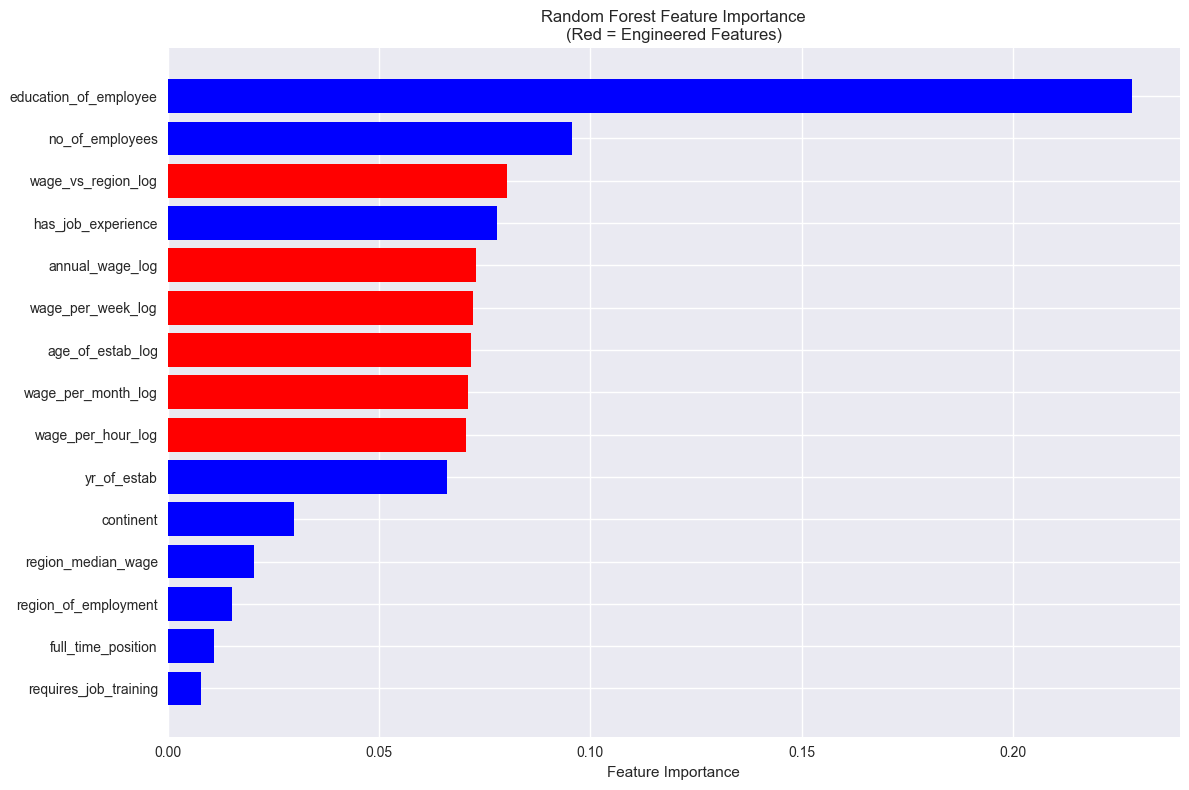

....Random Forest model completed...!


In [12]:
# Random Forest classifier
print("RANDOM FOREST CLASSIFIER")
print("EDA recommendation: Robust, captures interactions, insensitive to sclaing and moderate outlier outliers")

# Create Random Forest model
rf_model = RandomForestClassifier(n_estimators=100, random_state=234, n_jobs=-1)

# Train the model
rf_model.fit(X_train, y_train)

# Make predictions
y_train_pred_rf = rf_model.predict(X_train)
y_test_pred_rf = rf_model.predict(X_test)

# Calculate metrics
train_accuracy_rf = accuracy_score(y_train, y_train_pred_rf)
test_accuracy_rf = accuracy_score(y_test, y_test_pred_rf) 

train_f1_rf = f1_score(y_train, y_train_pred_rf, average='macro')
test_f1_rf = f1_score(y_test, y_test_pred_rf, average='macro')

print(f"\nRandom Forest Performance")
print(f"Training - Accuracy: {train_accuracy_rf:.3f}, Macro:{train_accuracy_rf:.3f}")
print(f"Test - Accuracy: {test_accuracy_rf:.3f}, Macro: {test_accuracy_rf:.3f}")

# Feature importance analysis
print(f"\nFeature Importance (Top 10):")
feature_importance_rf = pd.DataFrame({
    'feature': X_train.columns,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

for i, (_, row) in enumerate(feature_importance_rf.head(10).iterrows(), 1):
    print(f"{i:2d}. {row['feature']}: {row['importance']:.3f}")

# Visualize feature importance
plt.figure(figsize=(12, 8))
top_features_rf = feature_importance_rf.head(15)
colors = ['red' if any(keyword in f.lower() for keyword in ['ratio', 'interaction', 'balance', 'total', 'log']) else 'blue' for f in top_features_rf['feature']]

plt.barh(range(len(top_features_rf)), top_features_rf['importance'], color=colors)
plt.yticks(range(len(top_features_rf)), top_features_rf['feature'])
plt.xlabel('Feature Importance')
plt.title('Random Forest Feature Importance\n(Red = Engineered Features)')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

# Store Random Forest results
rf_results = {
    'model': 'Random Forest',
    'train_accuracy': train_accuracy_rf,
    'test_accuracy': test_accuracy_rf,
    'train_f1': train_f1_rf,

    'test_f1': test_f1_rf
}

print("....Random Forest model completed...!")

#### **4. XGBoost Classifier (EDA Recommendation)**

In [13]:
# XGBoost Classifier
print("......XGBoost CLASSIFIER.....")
print("EDA recommendation: Best performance for structured data, hhandles non-linearityand feature interaction automatically")

if XGBOOST_AVAILABLE:
    # Create XGBoost model
    xgb_model = xgb.XGBClassifier(n_estimators=100, random_state=42, eval_metric='mlogloss', n_jobs=-1)

    # Train the model(using encoded labels for XGBoost)
    xgb_model.fit(X_train, y_train)
    # Make predictions
    y_train_pred_xgb = xgb_model.predict(X_train)
    y_test_pred_xgb = xgb_model.predict(X_test)

    # Calculate the metrics using original labels
    train_accuracy_xgb = accuracy_score(y_train, y_train_pred_xgb)
    test_accuracy_xgb = accuracy_score(y_test, y_test_pred_xgb)

    train_f1_xgb = f1_score(y_train, y_train_pred_xgb, average='macro')
    test_f1_xgb = f1_score(y_test, y_test_pred_xgb, average='macro')

    print("f\nXGBoost Performance:")
    print(f"Training - Accuracy: {train_accuracy_xgb:.3f}, Macro: {train_accuracy_xgb:.3f}")
    print(f"Test - Accuracy: {test_accuracy_xgb:.3f}, Macro: {test_accuracy_xgb:.3f}")

    # Feature importance analysis
    print(f"\nFeature Importance (Top 10):")
    feature_importance_xgb = pd.DataFrame({
        'feature': X_train.columns,
        'importance': xgb_model.feature_importances_
    }).sort_values('importance', ascending=False)
    
    for i, (_, row) in enumerate(feature_importance_xgb.head(10).iterrows(), 1):
        print(f"{i:2d}. {row['feature']}: {row['importance']:.3f}")
    
    # Store XGBoost results
    xgb_results = {
        'model': 'XGBoost',
        'train_accuracy': train_accuracy_xgb,
        'test_accuracy': test_accuracy_xgb,
        'train_f1': train_f1_xgb,
        'test_f1': test_f1_xgb
    }
    
    print("XGBoost model completed!")
    
else:
    print("... XGBoost not available. Skipping XGBoost model.")
    xgb_results = None

......XGBoost CLASSIFIER.....
EDA recommendation: Best performance for structured data, hhandles non-linearityand feature interaction automatically
f
XGBoost Performance:
Training - Accuracy: 0.860, Macro: 0.860
Test - Accuracy: 0.784, Macro: 0.784

Feature Importance (Top 10):
 1. education_of_employee: 0.373
 2. has_job_experience: 0.214
 3. need_training_no_exp: 0.071
 4. full_time_position: 0.058
 5. region_median_wage: 0.052
 6. age_of_estab_log: 0.045
 7. continent: 0.035
 8. requires_job_training: 0.030
 9. wage_vs_region_log: 0.027
10. region_of_employment: 0.023
XGBoost model completed!


#### **5. Model Comparison and Evaluation**


MODEL COMPARISON AND EVALUATION

Model Performance Comparison:
Model           Train Acc  Test Acc   Test F1   
Logistic Regression 0.727      0.727      0.727     
Random Forest   1.000      0.763      0.763     
XGBoost         0.860      0.784      0.783     

Best Model: XGBoost (Test F1: 0.783)


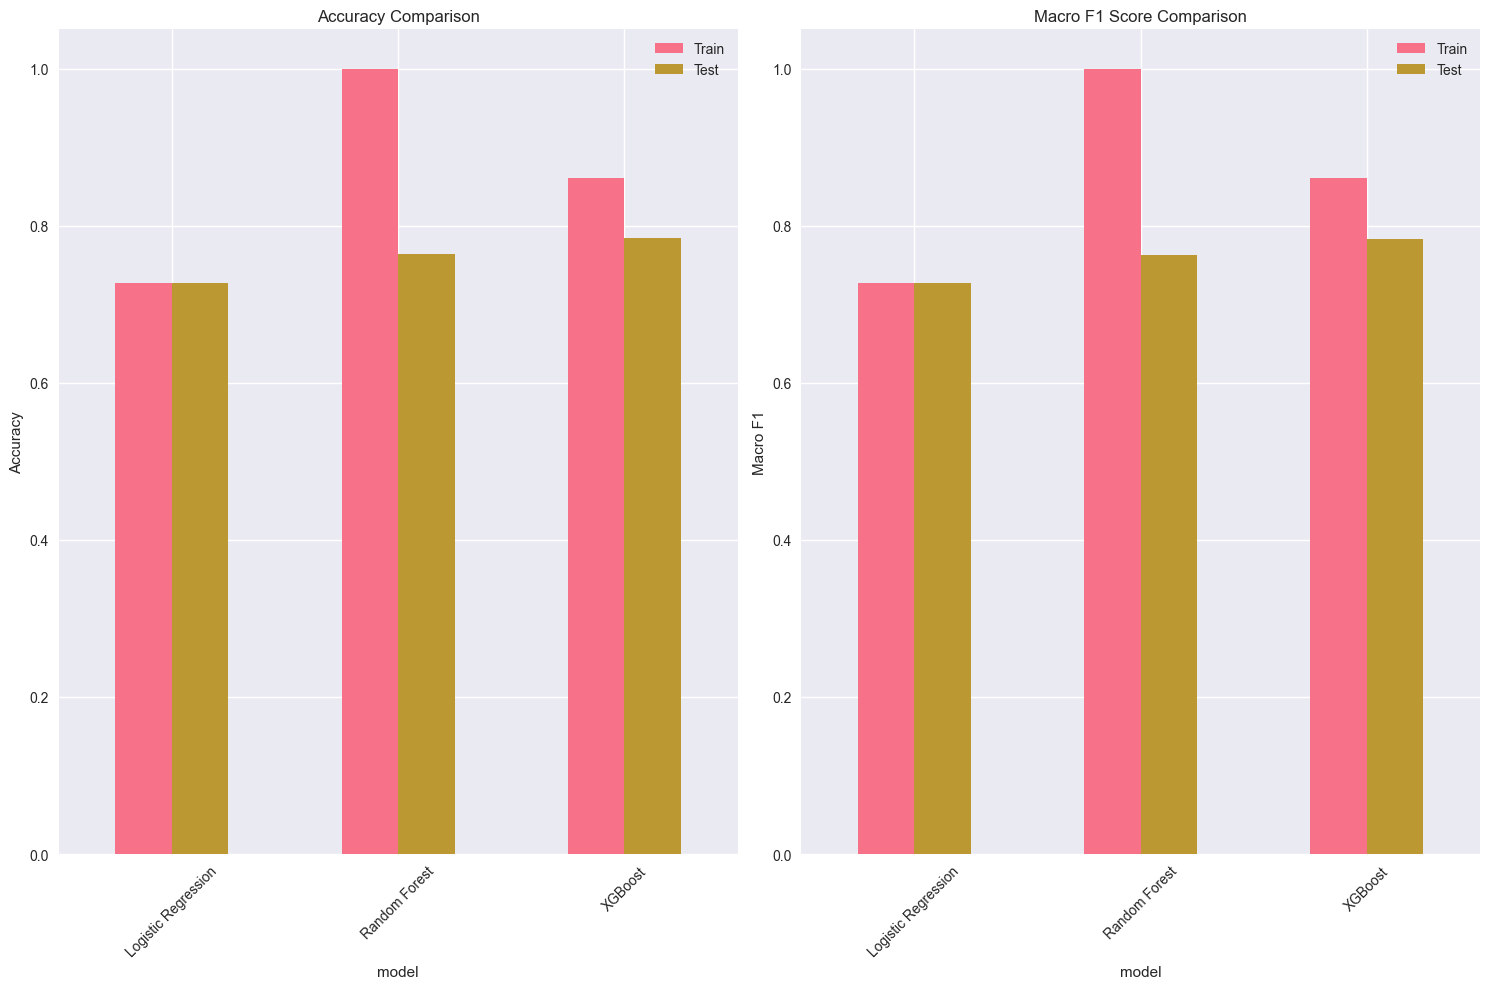

...Model comparison completed!


In [26]:

print("MODEL COMPARISON AND EVALUATION")

# Collect all results
all_results = [baseline_results, rf_results]
if xgb_results is not None:
    all_results.append(xgb_results)

# Create comparison DataFrame
comparison_df = pd.DataFrame(all_results)
comparison_df = comparison_df.set_index('model')

print("\nModel Performance Comparison:")
print("=" * 80)
print(f"{'Model':<15} {'Train Acc':<10} {'Test Acc':<10} {'Test F1':<10}")
print("=" * 80)
for _, row in comparison_df.iterrows():
    print(f"{row.name:<15} {row['train_accuracy']:<10.3f} {row['test_accuracy']:<10.3f} {row['test_f1']:<10.3f}")

# Find best model based on validation F1 score (EDA recommendation)
best_model_name = comparison_df['test_f1'].idxmax()
best_model_score = comparison_df.loc[best_model_name, 'test_f1']

print(f"\nBest Model: {best_model_name} (Test F1: {best_model_score:.3f})")

# Visualize model comparison
fig, axes = plt.subplots(1, 2,  figsize=(15, 10))

# Accuracy comparison
comparison_df[['train_accuracy', 'test_accuracy']].plot(kind='bar', ax=axes[0])
axes[0].set_title('Accuracy Comparison')
axes[0].set_ylabel('Accuracy')
axes[0].legend(['Train', 'Test'])
axes[0].tick_params(axis='x', rotation=45)

# F1 Score comparison
comparison_df[['train_f1', 'test_f1']].plot(kind='bar', ax=axes[1])
axes[1].set_title('Macro F1 Score Comparison')
axes[1].set_ylabel('Macro F1')
axes[1].legend(['Train', 'Test'])
axes[1].tick_params(axis='x', rotation=45)


plt.tight_layout()
plt.show()

print("...Model comparison completed!")

#### **6. Detailed Evaluation of Best Model**



DETAILED EVALUATION OF BEST MODEL
Best Model: XGBoost
Test F1 Score: 0.783

Detailed Classification Report for XGBoost:
              precision    recall  f1-score   support

           0       0.76      0.83      0.79      3421
           1       0.81      0.73      0.77      3387

    accuracy                           0.78      6808
   macro avg       0.79      0.78      0.78      6808
weighted avg       0.79      0.78      0.78      6808


Confusion Matrix for XGBoost:
[[2849  572]
 [ 898 2489]]


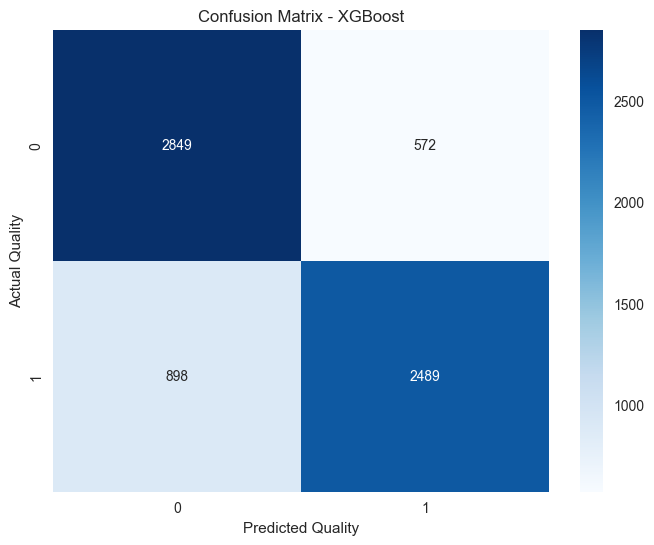


Per-class Performance for XGBoost:
Quality 0: 0.833 accuracy (3421 samples)
Quality 1: 0.735 accuracy (3387 samples)
...Detailed evaluation completed!


In [27]:
# Detailed evaluation of best model
print("DETAILED EVALUATION OF BEST MODEL")

# Get the best model
if best_model_name == 'Logistic Regression':
    best_model = baseline_model
    y_test_pred_best = y_test_pred
elif best_model_name == 'Random Forest':
    best_model = rf_model
    y_test_pred_best = y_test_pred_rf
elif best_model_name == 'XGBoost':
    best_model = xgb_model
    y_test_pred_best = y_test_pred_xgb

print(f"Best Model: {best_model_name}")
print(f"Test F1 Score: {best_model_score:.3f}")

# Detailed classification report
print(f"\nDetailed Classification Report for {best_model_name}:")
print("=" * 60)
print(classification_report(y_test, y_test_pred_best))

# Confusion matrix
print(f"\nConfusion Matrix for {best_model_name}:")
cm = confusion_matrix(y_test, y_test_pred_best)
print(cm)

# Visualize confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=sorted(y_test.unique()), 
            yticklabels=sorted(y_test.unique()))
plt.title(f'Confusion Matrix - {best_model_name}')
plt.xlabel('Predicted Quality')
plt.ylabel('Actual Quality')
plt.show()

# Per-class performance
print(f"\nPer-class Performance for {best_model_name}:")
unique_classes = sorted(y_test.unique())
for class_label in unique_classes:
    class_mask = y_test == class_label
    if class_mask.sum() > 0:  # Only if class exists in test set
        class_accuracy = accuracy_score(y_test[class_mask], y_test_pred_best[class_mask])
        print(f"Quality {class_label}: {class_accuracy:.3f} accuracy ({class_mask.sum()} samples)")

print("...Detailed evaluation completed!")
